## Prediction of Client Term Deposit Subscription

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import warnings

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
warnings.filterwarnings("ignore")
%matplotlib inline

### Data Loading

In [2]:
df = pd.read_csv("customer_data.csv")

In [3]:
print(df.shape)

(45211, 19)


In [4]:
print(list(df.columns))

['id', 'customer_age', 'job_type', 'marital', 'education', 'default', 'balance', 'housing_loan', 'personal_loan', 'communication_type', 'day_of_month', 'month', 'last_contact_duration', 'num_contacts_in_campaign', 'days_since_prev_campaign_contact', 'num_contacts_prev_campaign', 'prev_campaign_outcome', 'term_deposit_subscribed', 'spending_score']


In [5]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed,spending_score
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,email,26,jun,303.0,4.0,0.0,0,unknown,0.0,40
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0.0,83
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,0.0,0,unknown,0.0,12
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,email,20,may,127.0,3.0,0.0,0,unknown,0.0,81
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,0.0,0,unknown,0.0,80


### Data Exploration

In [6]:
df['education'].unique()

array(['tertiary', 'secondary', 'primary', 'unknown'], dtype=object)

In [7]:
df['term_deposit_subscribed'].value_counts()

0.0    41817
1.0     3394
Name: term_deposit_subscribed, dtype: int64

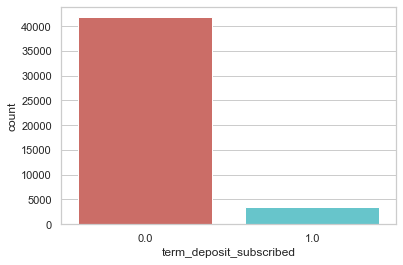

<Figure size 432x288 with 0 Axes>

In [8]:
sns.countplot(x='term_deposit_subscribed', data=df, palette='hls')
plt.show()
plt.savefig('count_plot')

There are 41817 no's and 3394 yes's in the outcome variables.

Let's get a sense of the numbers across the two classes

In [9]:
df.groupby('term_deposit_subscribed').mean()

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,spending_score
term_deposit_subscribed,,,,,,,,
0.0,39.562044,1304.543104,15.857857,230.573044,2.804362,38.485114,0.526795,52.985532
1.0,40.698291,1812.237478,15.172658,558.801120,2.124632,72.187979,1.239835,53.588391


#### Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't. The balance is understandably higher for the customers who bought it than the customers who did not. The last_contact_duration is considerably higher for the customer subscribing to the Term Deposit meaning that the better the chances of a sale.

Surprisingly, num_contacts_in_campaign (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit. But, one thing should also be noted that num_contacts_prev_campaign is higher meaning that the contacts made during previous campaign might have changed their mind towards the current campaign.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [10]:
df.groupby('job_type').mean()

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,term_deposit_subscribed,spending_score
job_type,,,,,,,,,
admin.,38.030748,1106.246567,15.564301,243.708567,2.567395,48.648424,0.671630,0.073487,53.004835
blue-collar,38.762844,1063.261919,15.442561,260.079120,2.803432,44.867345,0.505138,0.046547,52.701397
entrepreneur,40.635508,1519.390047,15.702085,253.439812,2.787492,33.334902,0.478144,0.051110,53.106254
housemaid,44.825806,1383.148387,16.002419,243.416129,2.801613,22.383065,0.371774,0.058871,52.748387
management,39.147283,1745.535631,16.114189,251.246669,2.851871,39.472404,0.668006,0.089342,53.193593
retired,60.130300,1923.390459,15.439488,282.617049,2.338781,38.228357,0.638693,0.152385,53.903710
self-employed,39.225459,1624.121596,16.027866,266.321723,2.848638,35.569348,0.551615,0.082331,53.030399
services,37.617959,985.255898,15.635532,255.939095,2.708714,42.825229,0.501204,0.055609,53.476890
student,25.705757,1352.733475,14.897655,245.470149,2.299574,57.737740,0.953092,0.190832,53.620469


In [11]:
df.groupby('marital').mean()

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,term_deposit_subscribed,spending_score
marital,,,,,,,,,
divorced,44.415927,1169.958542,15.790783,259.669880,2.619745,41.645970,0.548978,0.075588,53.744119
married,42.056487,1403.423600,15.850266,250.442995,2.832274,38.810108,0.557300,0.065132,52.949202
single,32.578029,1285.149615,15.707606,263.914506,2.639085,45.537404,0.642543,0.096417,52.930614
unknown,39.748918,1267.203463,16.463203,234.757576,2.796537,36.108225,0.554113,0.051948,52.095238


In [12]:
df.groupby('education').mean()

,customer_age,balance,day_of_month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,term_deposit_subscribed,spending_score
education,,,,,,,,,
primary,44.423588,1234.825281,15.421398,252.927748,2.829660,36.932857,0.489272,0.056634,52.973580
secondary,38.726705,1135.674209,15.759159,255.650504,2.689423,43.170158,0.567753,0.066417,53.146884
tertiary,38.292083,1740.559056,16.086535,255.716863,2.812646,39.824149,0.661980,0.097812,52.833095
unknown,43.236403,1476.540657,15.810985,254.573506,2.845450,37.682283,0.488422,0.088314,53.207324


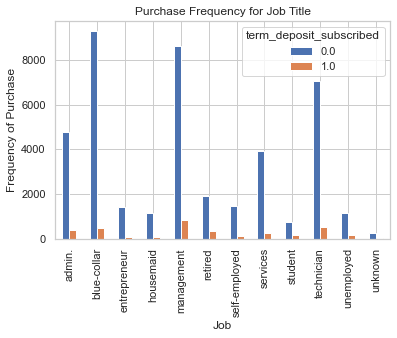

In [13]:
pd.crosstab(df.job_type, df.term_deposit_subscribed).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

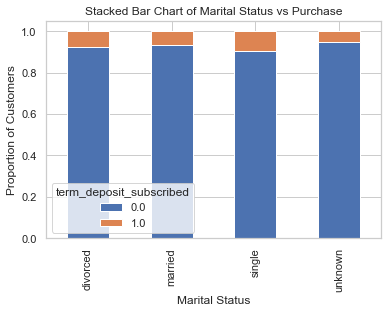

In [14]:
table=pd.crosstab(df.marital,df.term_deposit_subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

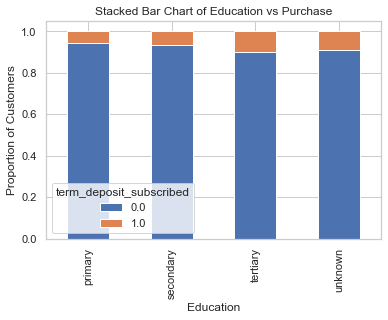

In [15]:
table=pd.crosstab(df.education,df.term_deposit_subscribed)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education seems a good predictor of the outcome variable.

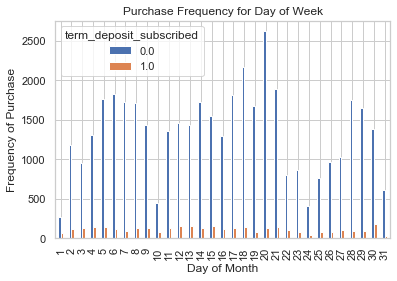

In [16]:
pd.crosstab(df.day_of_month,df.term_deposit_subscribed).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofmonth_bar')

Day of month may not be a good predictor of the outcome

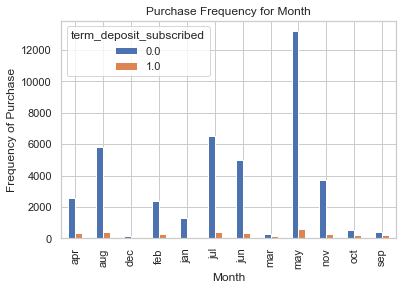

In [17]:
pd.crosstab(df.month,df.term_deposit_subscribed).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Month might be a good predictor of the outcome variable

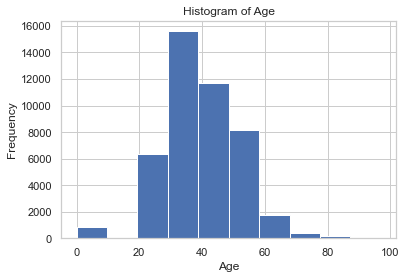

In [18]:
df.customer_age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

The most of the customers of the bank in this dataset are in the age range of 30-40.

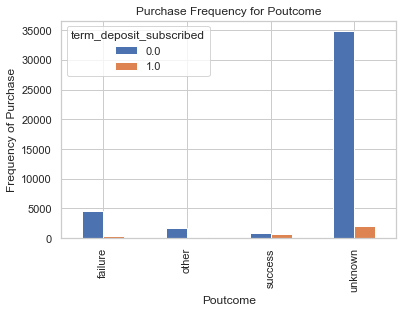

In [19]:
pd.crosstab(df.prev_campaign_outcome,df.term_deposit_subscribed).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

Prev_campaign_outcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [20]:
cat_vars = ['job_type','marital','education','default','housing_loan','personal_loan',
            'communication_type','day_of_month','month','prev_campaign_outcome']

df_new = None

for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df_new = df.join(cat_list)

In [21]:
cat_vars=['job_type','marital','education','default','housing_loan','personal_loan',
          'communication_type','day_of_month','month','prev_campaign_outcome']

data_vars = df_new.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [22]:
df_final = df_new[to_keep]
df_final.columns.values

array(['id', 'customer_age', 'balance', 'last_contact_duration',
       'num_contacts_in_campaign', 'days_since_prev_campaign_contact',
       'num_contacts_prev_campaign', 'term_deposit_subscribed',
       'spending_score', 'prev_campaign_outcome_failure',
       'prev_campaign_outcome_other', 'prev_campaign_outcome_success',
       'prev_campaign_outcome_unknown'], dtype=object)

In [23]:
df_final.shape

(45211, 13)

In [24]:
data_final_vars = df_final.columns.values.tolist()

y = ['term_deposit_subscribed']
X = [i for i in data_final_vars if i not in y]

In [25]:
X.remove('id')

In [26]:
temp = X

### Feature Selection

In [27]:
logreg = LogisticRegression()

rfe = RFE(logreg, 18)
rfe = rfe.fit(df_final[X], df_final[y] )
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


In [28]:
rk= rfe.ranking_

cols = []

for x,y in zip(rk, temp):
    if(x==1):
        cols.append(y)
        
print(cols)

['customer_age', 'balance', 'last_contact_duration', 'num_contacts_in_campaign', 'days_since_prev_campaign_contact', 'num_contacts_prev_campaign', 'spending_score', 'prev_campaign_outcome_failure', 'prev_campaign_outcome_other', 'prev_campaign_outcome_success', 'prev_campaign_outcome_unknown']


In [29]:
X = df_final[cols]
y = df_final['term_deposit_subscribed']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Implementing The Model

In [31]:
logit_model=sm.Logit(y,X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.206915
         Iterations 8
                              Logit Regression Results                             
Dep. Variable:     term_deposit_subscribed   No. Observations:                45211
Model:                               Logit   Df Residuals:                    45200
Method:                                MLE   Df Model:                           10
Date:                     Sun, 20 Jun 2021   Pseudo R-squ.:                  0.2238
Time:                             12:36:08   Log-Likelihood:                -9354.9
converged:                            True   LL-Null:                       -12051.
Covariance Type:                 nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
customer_age            

### Logistic Regression Model Fitting

In [32]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

#### Predicting the test set results and caculating the accuracy

In [33]:
y_pred = logreg.predict(X_test)

In [34]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


### Cross Validation

In [35]:
kfold = model_selection.KFold(n_splits=10, random_state=0)

modelCV = LogisticRegression()

scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)

print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.921


### Confusion Matrix

In [36]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[12487    89]
 [  922    66]]


In [37]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.93


#### Compute precision, recall, F-measure and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96     12576
         1.0       0.43      0.07      0.12       988

    accuracy                           0.93     13564
   macro avg       0.68      0.53      0.54     13564
weighted avg       0.89      0.93      0.90     13564



#### Interpretation:
    
Of the entire test set, 90% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 93% of the customer's preferred term deposit were promoted.

### ROC Curve

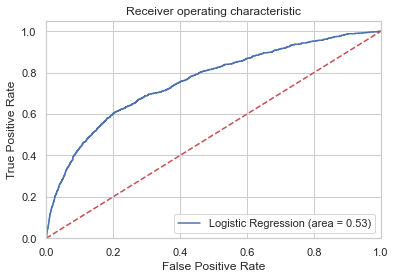

In [39]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Prediction On Test Data

In [40]:
print(X_test.shape)
print(list(X_test.columns))

(13564, 11)
['customer_age', 'balance', 'last_contact_duration', 'num_contacts_in_campaign', 'days_since_prev_campaign_contact', 'num_contacts_prev_campaign', 'spending_score', 'prev_campaign_outcome_failure', 'prev_campaign_outcome_other', 'prev_campaign_outcome_success', 'prev_campaign_outcome_unknown']


In [41]:
y_pred_testdata = logreg.predict(X_test)

In [42]:
print(len(y_pred_testdata))

13564


In [43]:
test_data = X_test
test_data['term_deposit_subscribed'] = y_pred_testdata
test_data.head()

,customer_age,balance,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,spending_score,prev_campaign_outcome_failure,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown,term_deposit_subscribed
14001,29.0,117.0,223.0,2.0,0.0,0,73,0,0,0,1,0.0
32046,39.0,3574.0,111.0,1.0,0.0,0,57,0,0,0,1,0.0
13318,51.0,-53.0,115.0,3.0,0.0,0,18,0,0,0,1,0.0
42991,27.0,65.0,580.0,4.0,0.0,0,69,0,0,0,1,0.0
14237,32.0,108.0,233.0,2.0,0.0,0,37,0,0,0,1,0.0


In [44]:
train_data = X_train
train_data['term_deposit_subscribed'] = logreg.predict(X_train)
train_data.head()

,customer_age,balance,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,spending_score,prev_campaign_outcome_failure,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown,term_deposit_subscribed
24951,59.0,-5.0,689.0,3.0,264.0,9,26,1,0,0,0,0.0
22129,42.0,4676.0,163.0,2.0,0.0,0,78,0,0,0,1,0.0
986,37.0,3593.0,33.0,1.0,0.0,0,85,0,0,0,1,0.0
14999,69.0,946.0,78.0,1.0,0.0,0,43,0,0,0,1,0.0
4027,27.0,-2.0,284.0,1.0,0.0,0,92,0,0,0,1,0.0


In [45]:
final_data = pd.concat([train_data, test_data], 0)
final_data = final_data.sort_index()
final_data.head()

,customer_age,balance,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,spending_score,prev_campaign_outcome_failure,prev_campaign_outcome_other,prev_campaign_outcome_success,prev_campaign_outcome_unknown,term_deposit_subscribed
0,28.0,285.0,303.0,4.0,0.0,0,40,0,0,0,1,0.0
1,34.0,934.0,143.0,2.0,132.0,1,83,0,1,0,0,0.0
2,46.0,656.0,101.0,4.0,0.0,0,12,0,0,0,1,0.0
3,34.0,2.0,127.0,3.0,0.0,0,81,0,0,0,1,0.0
4,41.0,1352.0,49.0,2.0,0.0,0,80,0,0,0,1,0.0


In [46]:
result = df
result = result.drop(['term_deposit_subscribed'], 1)
result['term_deposit_subscribed'] = final_data['term_deposit_subscribed']
result.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,spending_score,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,email,26,jun,303.0,4.0,0.0,0,unknown,40,0.0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,83,0.0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,0.0,0,unknown,12,0.0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,email,20,may,127.0,3.0,0.0,0,unknown,81,0.0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,0.0,0,unknown,80,0.0


In [47]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                45211 non-null  object 
 1   customer_age                      45211 non-null  float64
 2   job_type                          45211 non-null  object 
 3   marital                           45211 non-null  object 
 4   education                         45211 non-null  object 
 5   default                           45211 non-null  object 
 6   balance                           45211 non-null  float64
 7   housing_loan                      45211 non-null  object 
 8   personal_loan                     45211 non-null  object 
 9   communication_type                45211 non-null  object 
 10  day_of_month                      45211 non-null  int64  
 11  month                             45211 non-null  object 
 12  last

In [48]:
result.to_csv("result.csv", index=False)

### Support Vector Machine Model Fitting

In [49]:
clf = svm.SVC(kernel='linear', cache_size=7000)

In [ ]:
clf = clf.fit(X_train, y_train)

In [ ]:
predictions = clf.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
y_pred_testdata_svm = clf.predict(Z)

In [ ]:
y_pred_testdata_svm

In [ ]:
np.corrcoef(y_pred_testdata,y_pred_testdata_svm)